In [1]:
import torch
import torch.nn as nn
import torchvision.models as models

class h_sigmoid(nn.Module):
    def __init__(self, inplace=True):
        super(h_sigmoid, self).__init__()
        self.relu = nn.ReLU6(inplace=inplace)

    def forward(self, x):
        return self.relu(x + 3) / 6


class h_swish(nn.Module):
    def __init__(self, inplace=True):
        super(h_swish, self).__init__()
        self.sigmoid = h_sigmoid(inplace=inplace)

    def forward(self, x):
        return x * self.sigmoid(x)


class CoordAttention(nn.Module):

    def __init__(self, in_channels, out_channels, reduction=32):
        super(CoordAttention, self).__init__()
        self.pool_w, self.pool_h = nn.AdaptiveAvgPool2d((1, None)), nn.AdaptiveAvgPool2d((None, 1))
        temp_c = max(8, in_channels // reduction)
        self.conv1 = nn.Conv2d(in_channels, temp_c, kernel_size=1, stride=1, padding=0)

        self.bn1 = nn.BatchNorm2d(temp_c)
        self.act1 = h_swish()

        self.conv2 = nn.Conv2d(temp_c, out_channels, kernel_size=1, stride=1, padding=0)
        self.conv3 = nn.Conv2d(temp_c, out_channels, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        short = x
        n, c, H, W = x.shape
        x_h, x_w = self.pool_h(x), self.pool_w(x).permute(0, 1, 3, 2)
        x_cat = torch.cat([x_h, x_w], dim=2)
        out = self.act1(self.bn1(self.conv1(x_cat)))
        x_h, x_w = torch.split(out, [H, W], dim=2)
        x_w = x_w.permute(0, 1, 3, 2)
        out_h = torch.sigmoid(self.conv2(x_h))
        out_w = torch.sigmoid(self.conv3(x_w))
        return short * out_w * out_h

In [2]:
class ResNet18(nn.Module):
    def __init__(self, coord_attention=True):
        super(ResNet18, self).__init__()
        self.coord_attention = coord_attention
        self.model = models.resnet18(pretrained=False)
        self.model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.model.fc = nn.Linear(512, 100)
        if coord_attention:
            self.coord_att = CoordAttention(512, 512)

    def forward(self, x):
        x = self.model.conv1(x)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        x = self.model.maxpool(x)

        x = self.model.layer1(x)
        x = self.model.layer2(x)
        x = self.model.layer3(x)
        x = self.model.layer4(x)

        if self.coord_attention:
            x = self.coord_att(x)

        x = self.model.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.model.fc(x)
        return x

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import sys
from basic_tools import *

In [4]:
#一些参数的设置
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
learning_rate=0.01
momentum=0.9
weight_decay=0.0001
batch_size=128
epochs=100
data_path='./data'
model_name='CoordBasicResNet2_'+'epoch='+str(epochs)
print(device)
model=ResNet18(coord_attention=True).to(device)
criterion=nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

cuda:0


In [5]:
#数据集的加载
trainloader,testloader=get_data_loaders(train_batch_size=batch_size,test_batch_size=batch_size,data_path=data_path)

Files already downloaded and verified
Files already downloaded and verified


epoch:0,train_loss:4.1929,train_acc:6.7240,train_top5_acc:21.4640,test_loss:3.7655,test_acc:12.1300,test_top5_acc:35.5000
epoch:1,train_loss:3.5635,train_acc:15.1060,train_top5_acc:40.0700,test_loss:3.3600,test_acc:18.9700,test_top5_acc:46.1200
epoch:2,train_loss:3.1720,train_acc:21.7260,train_top5_acc:51.1900,test_loss:3.0220,test_acc:24.0200,test_top5_acc:55.1000
epoch:3,train_loss:2.8371,train_acc:27.8540,train_top5_acc:59.4600,test_loss:2.7115,test_acc:30.3400,test_top5_acc:62.0400
epoch:4,train_loss:2.5976,train_acc:32.5120,train_top5_acc:65.0820,test_loss:2.4498,test_acc:35.6400,test_top5_acc:68.1900
epoch:5,train_loss:2.4030,train_acc:36.7220,train_top5_acc:69.1700,test_loss:2.2880,test_acc:39.2100,test_top5_acc:71.6900
epoch:6,train_loss:2.2291,train_acc:40.3460,train_top5_acc:73.1440,test_loss:2.1693,test_acc:41.7000,test_top5_acc:74.2700
epoch:7,train_loss:2.0948,train_acc:43.3780,train_top5_acc:75.9420,test_loss:2.1763,test_acc:42.0700,test_top5_acc:73.9800
epoch:8,train_los

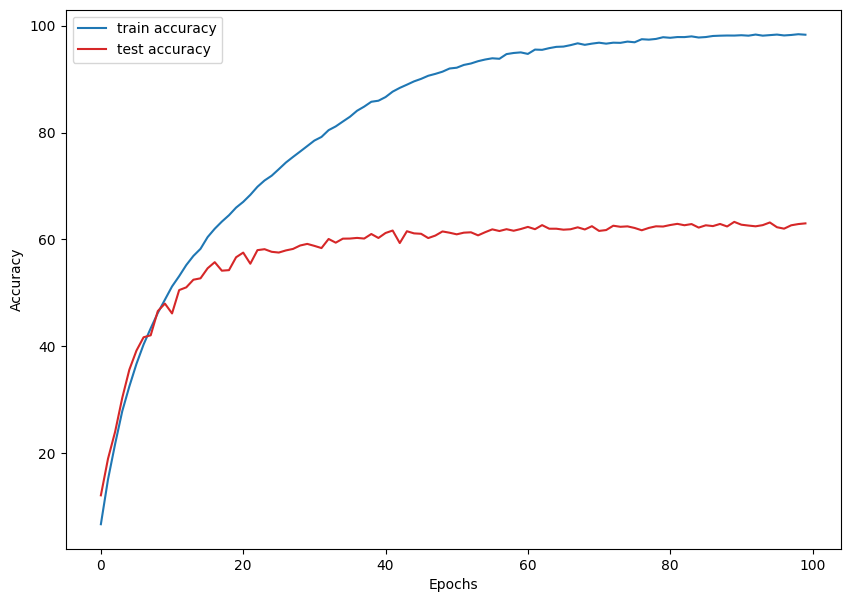

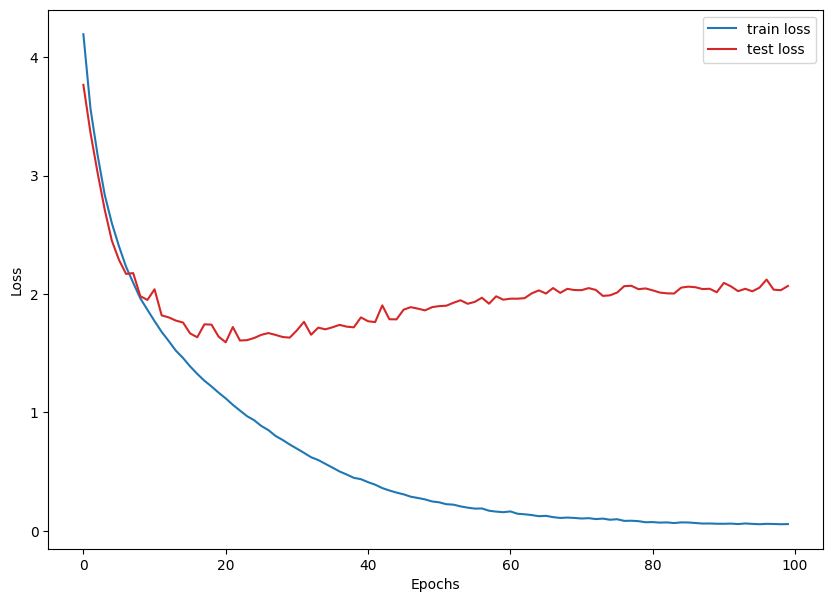

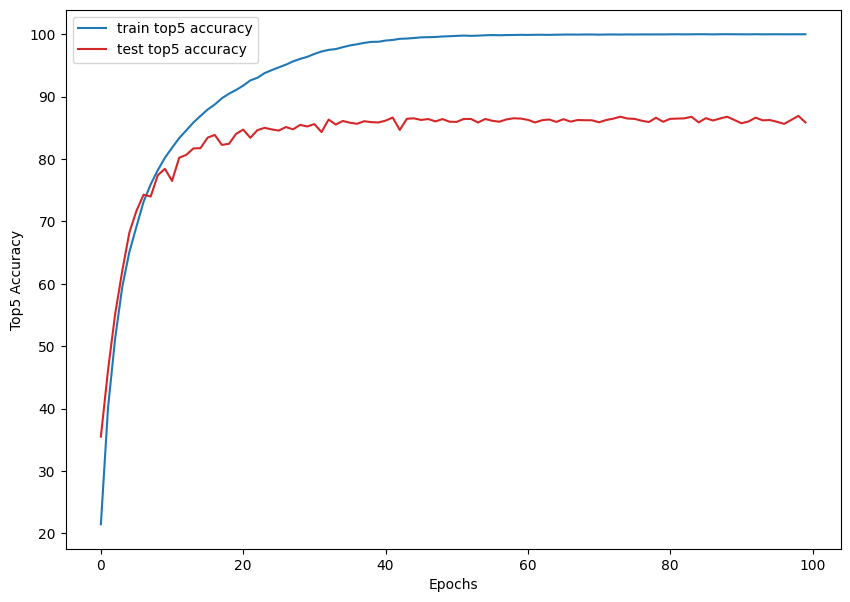

In [6]:
#训练之
train_lossa, test_lossa = [], []
train_acca, test_acca = [], []
train_top5_acca, test_top5_acca = [], []
for epoch in range(epochs):
    train_loss,train_acc,train_top5_acc=train(model,trainloader,criterion,optimizer,device)
    test_loss,test_acc,test_top5_acc=test(model,testloader,criterion,device)
    print('epoch:{},train_loss:{:.4f},train_acc:{:.4f},train_top5_acc:{:.4f},test_loss:{:.4f},test_acc:{:.4f},test_top5_acc:{:.4f}'.format(epoch,train_loss,train_acc,train_top5_acc,test_loss,test_acc,test_top5_acc))
    #torch.save(model.state_dict(), model_name+'.pth')
    train_lossa.append(train_loss)
    test_lossa.append(test_loss)
    train_acca.append(train_acc)
    test_acca.append(test_acc)
    train_top5_acca.append(train_top5_acc)
    test_top5_acca.append(test_top5_acc)

#画图
save_plots(train_acca,test_acca,train_lossa,test_lossa,train_top5_acca,test_top5_acca,model_name)
save_log(model_name,train_acca,test_acca,train_lossa,test_lossa,train_top5_acca,test_top5_acca)
save_model_info(model_name,model,train_acca,test_acca,train_lossa,test_lossa,train_top5_acca,test_top5_acca,learning_rate,epochs,momentum,weight_decay)

In [7]:
#固定模型
import os
modelpath='./models/'
if not os.path.exists(modelpath):
    os.makedirs(modelpath)
torch.save(model.state_dict(),modelpath+model_name+'.pth')